In [1]:
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.animation import FuncAnimation
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
from IPython.display import HTML
import torch
from tqdm import tqdm 
import os
import pandas as pd
import umap
from tqdm import tqdm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn import svm
import re
from transformers import LlamaTokenizer, LlamaForCausalLM, GenerationConfig
from sklearn.preprocessing import OneHotEncoder

In [2]:
tokenizer = LlamaTokenizer.from_pretrained('../../models/llama-7b-hf', local_files_only=True)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LLaMATokenizer'. 
The class this function is called from is 'LlamaTokenizer'.


In [3]:
def extract_number(filename):
    match = re.search(r'\d+', filename)
    return int(match.group()) if match else float('inf')

def sort_files(activations_directory):
  activation_folder_list = os.listdir(activations_directory)
  activation_folder_list = sorted(activation_folder_list, key=extract_number, reverse=False)
  return activation_folder_list 


In [29]:

# Assuming a data set with variable length tokens, token_output_focus determines which token to focus on for each element of the data set
# Assumes filename corresponds to the class of the prompt
def build_activations_array(activations_directory, activation_folder_list, token_output_focus = "first", first_n_files=None):
  if first_n_files is None:
    first_n_files = len(activation_folder_list)

  # Array of arrays 
  all_prompt_activations = [] 
  all_prompt_filenames = []
  all_prompt_tokens = []

  # Load the CSV file into a pandas DataFrame
  df = pd.read_csv(activations_directory+'Task.csv')

  # Create a dictionary that maps question IDs to classes
  id_to_class = df.set_index('Question_ID')['Class'].to_dict()
  id_to_q_type = df.set_index('Question_ID')['Question_Type'].to_dict()
#   print(id_to_class)
#   print(id_to_q_type)

  activation_folder_list = [f for f in activation_folder_list if os.path.splitext(f)[1] == '.pt']

  for activation_file in tqdm((activation_folder_list[:first_n_files]), position=0, leave=True):
      # Extract the question ID from the filename
      question_id = int(re.search(r"^Question_(\d+)_", activation_file).group(1))
      
      # Check if the question type is 'character_qa_close' before proceeding
      if id_to_q_type[question_id] == 'character_qa_close':
#           Use the dictionary to get the corresponding class
#       if 1:

          activation_path = os.path.join(activations_directory,str(activation_file))
          data = torch.load(activation_path, map_location=torch.device('cpu'))


          hidden_states = data['hidden_states']
          output_response = data['output'].split("Response:")[1]
          tokenized_output_response = tokenizer.encode(output_response)

          

          if token_output_focus == "first":
            token_id = 3 # Disregard first hidden state (which inclued all input? tokens), and disregard first two tokens (['', '<0x0A>',)
          if token_output_focus == "last":
              token_id = len(hidden_states) - 1
              token_text = tokenizer.decode(tokenized_output_response[token_id])
              # Check if token_text is not one of the specified strings
#               if token_text not in ["Yes", "yes", "No", "no"]:
#                   token_id = len(hidden_states) - 2 # n-1 to avoid full stop
#                   token_text = tokenizer.decode(tokenized_output_response[token_id])
#                   if token_text not in ["Yes", "yes", "No", "no"]:
#                     print("output neither yes or no")
#                     continue

          filename = id_to_class[question_id] +'_'+ id_to_q_type[question_id]+'_'+token_text
#           filename = id_to_class[question_id]
          all_prompt_filenames.append(filename)
          
          token_hidden_states = hidden_states[token_id]

          # Initialize an empty dictionary to store activations
          activations = []

          # iterate through all layers for each token's hidden states
          for layer_id, layers in enumerate(token_hidden_states):
            # print("Layer: "+str(layer_id))
            for beam_id, beams in enumerate(layers):
              # print("Beam: "+str(beam_id))
              for token_activation_id, token_activations in enumerate(beams):
                # print(token_activations.shape)
                token_activations_np = token_activations.numpy()  # Detach and convert to NumPy array
                activations.extend(token_activations_np)
          token_text = tokenizer.decode(tokenized_output_response[token_id])
          all_prompt_activations.append(activations)
          all_prompt_tokens.append(token_text)

  return all_prompt_activations, all_prompt_filenames, all_prompt_tokens

In [30]:
activations_directory = "/home/gridsan/wzulfikar/activations/dataset_trex/"
#Sort files
activation_folder_list = sort_files(activations_directory)
#Set params
token_output_focus = "last"
first_n_files = 800

all_prompt_activations, all_prompt_filenames, all_prompt_tokens = build_activations_array(activations_directory, activation_folder_list, token_output_focus = token_output_focus, first_n_files = first_n_files)

100%|██████████| 800/800 [00:39<00:00, 20.28it/s]


In [33]:
unique_strings = set(all_prompt_filenames)

for unique_string in unique_strings:
    print(unique_string)

Vincent Van Gogh_character_qa_open_3
Marie Curie_character_qa_open_and
Vincent Van Gogh_character_qa_open_ity
William Shakespeare_character_qa_close_Yes
William Shakespeare_character_qa_open_iam
William Shakespeare_character_qa_close_.
Hermione Granger_character_qa_close_Yes
William Shakespeare_character_qa_open_ane
Vincent Van Gogh_character_qa_close_No
Marie Curie_character_qa_close_Yes
William Shakespeare_character_qa_open_.
Ada Lovelace_character_qa_open_".
Isaac Newton_character_qa_open_ton
Hermione Granger_character_qa_open_.
Hermione Granger_character_qa_open_ale
Princess Leia_character_qa_open_ale
Princess Leia_character_qa_open_Blue
Isaac Newton_character_qa_close_.
Lady Gaga_character_qa_open_.
Cleopatra_character_qa_open_0
Vincent Van Gogh_character_qa_open_ry
Marie Curie_character_qa_open_Blue
Lady Gaga_character_qa_open_anne
Cleopatra_character_qa_open_atra
Ada Lovelace_character_qa_close_.
Sherlock Holmes_character_qa_open_January
Vincent Van Gogh_character_qa_close_Yes
V

In [35]:
import cudf
import cuml

start = time.time()

all_prompt_activations = np.array(all_prompt_activations)
print(all_prompt_activations.shape)

trials = all_prompt_activations.shape[0]
n_neurons = all_prompt_activations.shape[1]

# Convert your data to cuDF DataFrame, because cuML works with cuDF DataFrame
# df = cudf.DataFrame(all_prompt_activations, columns=[f'feature_{i+1}' for i in range(n_neurons)])

pca_float = PCA(n_components = 32)

all_prompt_activations_pca = pca_float.fit_transform(all_prompt_activations)

print(f'explained variance: {pca_float.explained_variance_}')
print(f'explained variance ratio: {pca_float.explained_variance_ratio_}')

print("Time taken", time.time()-start)

(800, 209920)
explained variance: [1.18665433e+05 6.62703260e+03 1.88858321e+03 1.59072848e+03
 1.27660080e+03 1.24168612e+03 1.03058733e+03 7.72712189e+02
 6.70356441e+02 6.10787892e+02 5.93520911e+02 4.70154130e+02
 4.35363410e+02 3.92376550e+02 3.35861560e+02 3.22560800e+02
 2.90993716e+02 2.46924660e+02 2.28282236e+02 2.04142277e+02
 1.88294831e+02 1.76106626e+02 1.50076611e+02 1.30396687e+02
 1.21554330e+02 1.11531276e+02 1.03225153e+02 9.65940743e+01
 8.87588422e+01 8.28394967e+01 7.69453178e+01 7.43750974e+01]
explained variance ratio: [8.35851144e-01 4.66792447e-02 1.33027319e-02 1.12047138e-02
 8.99207303e-03 8.74614233e-03 7.25921252e-03 5.44280126e-03
 4.72183166e-03 4.30224494e-03 4.18062043e-03 3.31165410e-03
 3.06659653e-03 2.76380729e-03 2.36572911e-03 2.27204172e-03
 2.04969067e-03 1.73927870e-03 1.60796589e-03 1.43792975e-03
 1.32630410e-03 1.24045327e-03 1.05710403e-03 9.18483314e-04
 8.56199849e-04 7.85599836e-04 7.27093481e-04 6.80385733e-04
 6.25196218e-04 5.835017

In [23]:
print(all_prompt_activations_pca.shape)

(379, 16)


In [7]:
clustering_data = np.array(all_prompt_activations).T
target = np.array(all_prompt_filenames)[:, np.newaxis]
target = OneHotEncoder().fit_transform(target)

print(clustering_data.shape)
print(target.shape)


(209920, 800)
(800, 14)


In [8]:
classes = set(all_prompt_filenames)
all_prompt_activations_with_class = {k:[] for k in classes}
for j, activation in enumerate(all_prompt_activations):
    k = all_prompt_filenames[j]
    all_prompt_activations_with_class[k].append(np.array(activation))

print(all_prompt_activations_with_class.keys())

dict_keys(['Ada Lovelace', 'Vincent Van Gogh', 'Princess Leia', 'William Shakespeare', 'Albert Einstein', 'Sherlock Holmes', 'Marie Curie', 'Harry Potter', 'Lady Gaga', 'Isaac Newton', 'Barney the Dinosaur', 'Socrates', 'Cleopatra', 'Hermione Granger'])


In [38]:
df = pd.read_csv(activations_directory+'Task.csv')
print(df.head())
# print length of df
print(len(df))
# print the columns of df
print(df.columns)

   Question_ID                                           Question  \
0            1  Pretend to be Albert Einstein, what is your fi...   
1            2  Pretend to be Albert Einstein, what is your la...   
2            3  Pretend to be Albert Einstein, what is your na...   
3            4  Pretend to be Albert Einstein, what is your ge...   
4            5  Pretend to be Albert Einstein, what is your oc...   

       Question_Type            Class  
0  character_qa_open  Albert Einstein  
1  character_qa_open  Albert Einstein  
2  character_qa_open  Albert Einstein  
3  character_qa_open  Albert Einstein  
4  character_qa_open  Albert Einstein  
1129
Index(['Question_ID', 'Question', 'Question_Type', 'Class'], dtype='object')


## CPU

In [21]:
start = time.time()
mapper = umap.UMAP(random_state=42, n_components=2).fit(clustering_data)

print("Time taken", time.time()-start)

/home/gridsan/wzulfikar/.conda/envs/openllm/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
labels = [str(i) for i in range(15)]
umap.plot.points(mapper, labels=labels)

## GPU

In [67]:
from cuml.manifold.umap import UMAP as cumlUMAP
import time
start = time.time()

cuml_umap = cumlUMAP(n_components=2, n_neighbors=16, init="spectral")
embedding = cuml_umap.fit_transform(clustering_data)
print("Time taken", time.time()-start)

Time taken 13.812620401382446


In [68]:
print(embedding.shape)

(209920, 2)


/state/partition1/slurm_tmp/22773281.0.0/ipykernel_30667/4186800325.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[:,1], embedding[:,0], s=0.3, cmap='Spectral', alpha=1.0)


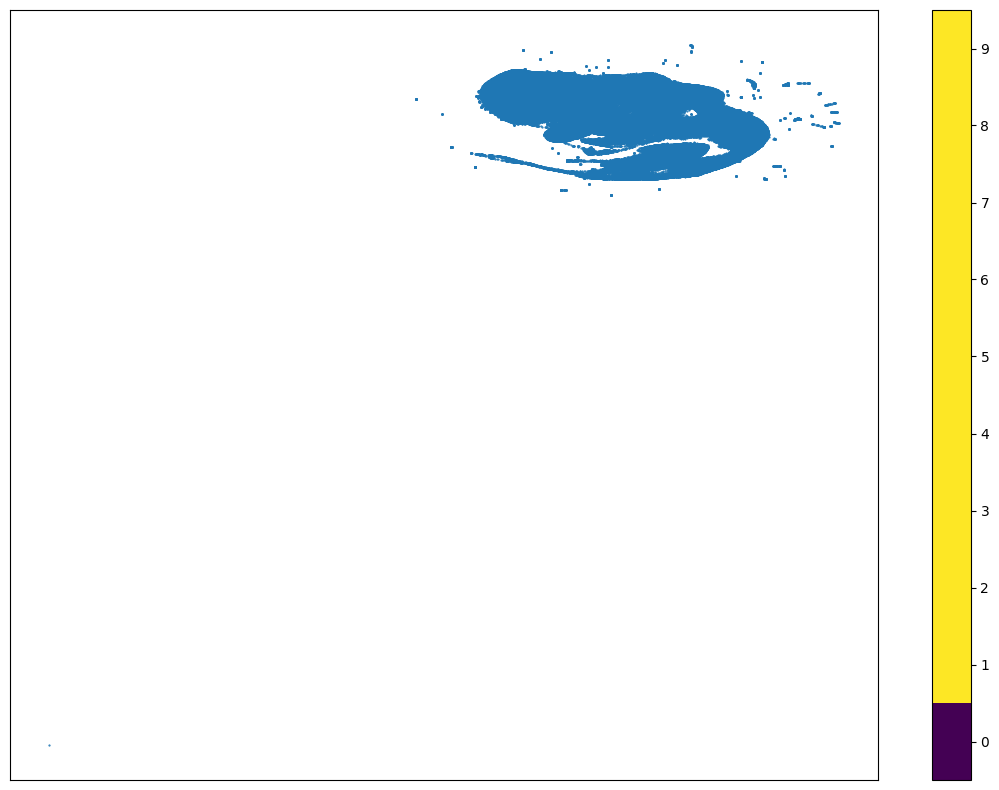

In [70]:
# g_embedding_numpy = embedding.to_pandas().values #it is necessary to convert to numpy array to do the visual mapping

fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(embedding[:,1], embedding[:,0], s=0.3, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))

In [9]:
# Assuming embedding is your data and its shape is [n_neurons, features]
# n_neurons = embedding.shape[0]
# features = embedding.shape[1]
import cudf
import cuml

start = time.time()

embedding = clustering_data

n_neurons = embedding.shape[0]
features = embedding.shape[1]

# Convert your data to cuDF DataFrame, because cuML works with cuDF DataFrame
df = cudf.DataFrame(embedding, columns=[f'feature_{i+1}' for i in range(features)])

# Initialize the KMeans model
kmeans = cuml.KMeans(n_clusters=16)

print("Fitting")
# Fit the model
kmeans.fit(df)

# Get cluster predictions
df['cluster'] = kmeans.predict(df)

# # Plotting
# plt.figure(figsize=(10, 8))
# for i in range(16):
#     cluster_data = df[df['cluster'] == i].to_pandas()
#     plt.scatter(cluster_data['feature_1'], cluster_data['feature_2'], label=f'Cluster {i+1}')

# plt.title('KMeans Clustering with cuML')
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.legend()
# plt.show()



print("Time taken ", time.time() - start)

Fitting


Fitting


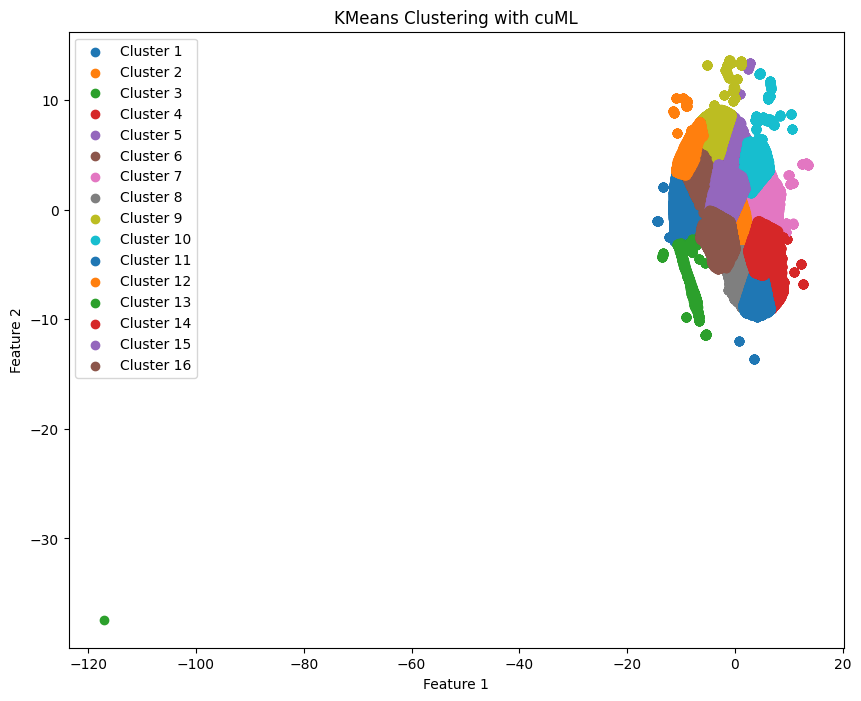

In [71]:
# Assuming embedding is your data and its shape is [n_neurons, features]
# n_neurons = embedding.shape[0]
# features = embedding.shape[1]
import cudf
import cuml

n_neurons = embedding.shape[0]
features = 2

# Convert your data to cuDF DataFrame, because cuML works with cuDF DataFrame
df = cudf.DataFrame(embedding, columns=[f'feature_{i+1}' for i in range(features)])

# Initialize the KMeans model
kmeans = cuml.KMeans(n_clusters=16)

print("Fitting")
# Fit the model
kmeans.fit(df)

# Get cluster predictions
df['cluster'] = kmeans.predict(df)

# Plotting
plt.figure(figsize=(10, 8))
for i in range(16):
    cluster_data = df[df['cluster'] == i].to_pandas()
    plt.scatter(cluster_data['feature_1'], cluster_data['feature_2'], label=f'Cluster {i+1}')

plt.title('KMeans Clustering with cuML')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()


In [11]:
indices = df.loc[df['cluster'] == 1].index
print(indices)

Int64Index([ 38071,  43191,  48311,  53431,  58551,  63671,  68791,  73911,
             79031,  84151,  89271,  94391,  99511, 104631, 109751, 114871,
            119991, 125111, 130231, 135351, 140471, 145591, 150711, 155831,
            160951, 166071, 171191, 176311, 191671, 196791, 201911],
           dtype='int64')


In [10]:
import numpy as np
import pandas as pd
import cudf
import cuml
from collections import defaultdict
import matplotlib.pyplot as plt

correlation_results = defaultdict(list)

for class_name, trials in all_prompt_activations_with_class.items():
    for cluster_id in range(16):  # Assuming you have 16 clusters
        cluster_neurons = df.loc[df['cluster'] == cluster_id].index.to_numpy()
        num_neurons = len(cluster_neurons)

        correlation_sum = 0
        for trial in trials:
            cluster_activations = trial[cluster_neurons]
#             correlation_sum += np.corrcoef(trial, cluster_activations)[0, 1]
            correlation_sum = np.mean(cluster_activations)

        average_correlation = correlation_sum / len(trials)
        correlation_results[class_name].append((cluster_id, num_neurons, average_correlation))

# Now let's get top 5 clusters for each class
for class_name, correlations in correlation_results.items():
    correlations.sort(key=lambda x: x[2], reverse=True)  # Sort by correlation value in descending order
    top_5_clusters = correlations[:5]

    print(f"For class {class_name}, the top 5 clusters are:")
    for cluster_id, num_neurons, correlation in top_5_clusters:
        print(f"Cluster ID: {cluster_id}, Number of neurons: {num_neurons}, Correlation: {correlation}")
    print()


For class Ada Lovelace, the top 5 clusters are:
Cluster ID: 3, Number of neurons: 33, Correlation: 142.5
Cluster ID: 0, Number of neurons: 33, Correlation: 64.35714285714286
Cluster ID: 4, Number of neurons: 33, Correlation: 24.553571428571427
Cluster ID: 9, Number of neurons: 284, Correlation: 1.2109375
Cluster ID: 12, Number of neurons: 44927, Correlation: 0.17424665178571427

For class Vincent Van Gogh, the top 5 clusters are:
Cluster ID: 3, Number of neurons: 33, Correlation: 135.25423728813558
Cluster ID: 0, Number of neurons: 33, Correlation: 61.186440677966104
Cluster ID: 4, Number of neurons: 33, Correlation: 23.322033898305083
Cluster ID: 9, Number of neurons: 284, Correlation: 1.152542372881356
Cluster ID: 12, Number of neurons: 44927, Correlation: 0.1651218220338983

For class Princess Leia, the top 5 clusters are:
Cluster ID: 3, Number of neurons: 33, Correlation: 134.64406779661016
Cluster ID: 0, Number of neurons: 33, Correlation: 60.88135593220339
Cluster ID: 4, Number o

In [ ]:
200,000, 379 - (hidden_States) number of layers*layer_size

pretend you are pranav, are you a boy? Yes